# Model Creation and Tuning

In [4]:
!pip install xgboost

     |████████████████████████████████| 173.6 MB 2.2 kB/s  eta 0:00:01


In [115]:
!pip install hyperopt

     |████████████████████████████████| 1.6 MB 3.0 MB/s eta 0:00:01
     |████████████████████████████████| 198 kB 12.0 MB/s eta 0:00:01


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import sklearn
import os 
import sys
import json

In [2]:
import pickle

In [3]:
from sklearn.metrics import *

In [4]:
from sklearn.model_selection import *
from sklearn.metrics import *

from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder

In [5]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [32]:
# import keras
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [120]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [35]:
from tensorflow.keras.optimizers import Adam

## Data Preprocessing

In [7]:
data = pd.read_csv('processed/training_df.csv')

In [8]:
data.drop(columns=['Unnamed: 0'], inplace = True)

In [9]:
data.columns

Index(['isAdult', 'startYear', 'runtimeMinutes', 'averageRating', 'numVotes',
       'cast_mean', 'cast_std', 'cast_max', 'crew_mean', 'crew_std',
       'crew_max', 'cast_exp', 'crew_exp', 'numRegions', 'Action', 'Adult',
       'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Family', 'Fantasy', 'Film-Noir', 'Game-Show', 'History',
       'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Reality-TV',
       'Romance', 'Sci-Fi', 'Short', 'Sport', 'Talk-Show', 'Thriller', 'War',
       'Western'],
      dtype='object')

In [10]:
label = 'averageRating'
numerical_cols = ['runtimeMinutes', 'numVotes','cast_mean', 
                  'cast_std', 'cast_max', 'crew_mean', 'crew_std',
                'crew_max', 'cast_exp', 'crew_exp', 'numRegions']
ordinal_cols = ['startYear']

In [11]:
def scaler(data, numerical_cols, ordinal_cols):
    if numerical_cols:
        ss  = StandardScaler()
        data.loc[:, numerical_cols] = ss.fit_transform(data[numerical_cols])
    if ordinal_cols:
        os = OrdinalEncoder()
        data.loc[:, ordinal_cols] = ss.fit_transform(data[ordinal_cols])
        
    return data

In [12]:
data_scaled = scaler(data, numerical_cols, ordinal_cols)

In [13]:
data_scaled

,isAdult,startYear,runtimeMinutes,averageRating,numVotes,cast_mean,cast_std,cast_max,crew_mean,crew_std,...,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
0,0,-1.319724,0.068700,4.5,-0.095872,-1.947168,-0.997854,-3.015751,-0.986950,1.005087,...,0,0,0,0,0,0,0,0,0,0
1,0,-1.319724,-0.166455,6.0,-0.072000,-0.208452,-0.997854,-1.450210,-0.472322,-0.953246,...,0,0,0,0,0,0,0,0,0,0
2,0,-1.319724,-0.009685,4.6,-0.095775,-1.160606,-0.997854,-1.737226,-1.630350,-0.408200,...,0,0,0,0,0,0,0,0,0,0
3,0,-1.319724,0.037346,4.5,-0.095581,-1.599425,-0.997854,-2.389535,-1.668844,-0.953246,...,0,0,0,0,0,0,0,0,0,0
4,0,-1.319724,0.303856,3.8,-0.095549,-0.976385,1.338778,-0.771809,-0.473268,1.763490,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323829,0,1.161934,0.005992,6.4,0.047136,-0.035898,-0.997854,0.193608,0.164157,-0.953246,...,0,0,0,0,0,0,0,0,0,0
323830,0,1.112301,0.013831,3.8,-0.095872,-1.897582,-0.997854,-2.406930,-1.755456,1.167940,...,0,0,0,0,0,0,0,0,1,0
323831,0,1.112301,-0.636766,9.3,-0.095775,3.616722,-0.997854,1.993980,3.566343,-0.953246,...,0,0,0,0,0,0,0,0,0,0
323832,0,1.112301,0.248986,8.3,-0.096130,1.261004,-0.997854,0.950286,1.006749,-0.953246,...,0,0,0,0,0,0,0,0,0,0


In [14]:
X = data_scaled[['isAdult', 'startYear', 'runtimeMinutes', 'numVotes',
       'cast_mean', 'cast_std', 'cast_max', 'crew_mean', 'crew_std',
       'crew_max', 'cast_exp', 'crew_exp', 'numRegions', 'Action', 'Adult',
       'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Family', 'Fantasy', 'Film-Noir', 'Game-Show', 'History',
       'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Reality-TV',
       'Romance', 'Sci-Fi', 'Short', 'Sport', 'Talk-Show', 'Thriller', 'War',
       'Western']].values

In [15]:
y = data[label]

In [16]:
X.shape, y.shape

((323834, 41), (323834,))

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 42)

In [18]:
print(f"Xtrain shape: {X_train.shape}")
print(f"Xtrain shape: {X_test.shape}")
print(f"Xtrain shape: {y_train.shape}")
print(f"Xtrain shape: {y_test.shape}")

Xtrain shape: (226683, 41)
Xtrain shape: (97151, 41)
Xtrain shape: (226683,)
Xtrain shape: (97151,)


## Baseline Linear Model

In [19]:
lr = LinearRegression(n_jobs=-1)

In [20]:
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [21]:

lr.score(X_train, y_train)

0.7430537794248169

In [22]:
lr.score(X_test, y_test)

0.7456695128983963

## Baseline Random Forest

In [36]:
rf_model = RandomForestRegressor(n_jobs=-1)
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [37]:
rf_model.score(X_train, y_train)

0.9759075492103017

In [38]:
rf_model.score(X_test, y_test)

0.830430301030396

In [39]:
rf_model.feature_importances_

array([2.45319173e-04, 1.33528929e-02, 1.32591878e-02, 1.82988987e-02,
       2.03452145e-01, 3.26198968e-02, 3.48809225e-02, 5.81235453e-01,
       2.37546969e-02, 2.65316066e-02, 1.46335730e-02, 1.50484753e-02,
       7.44189419e-03, 1.07208672e-03, 2.70124295e-04, 8.41037091e-04,
       3.67760546e-04, 4.15762509e-04, 1.50786270e-03, 8.75111623e-04,
       1.15073636e-03, 1.71793956e-03, 5.73897828e-04, 4.81125858e-04,
       1.80650029e-05, 2.05219258e-07, 3.89712630e-04, 7.91241762e-04,
       4.38633565e-04, 4.71487073e-04, 4.62407479e-04, 5.36226420e-05,
       2.83866000e-05, 1.00515746e-03, 6.00836522e-04, 1.63999764e-07,
       2.37333054e-04, 7.86576968e-07, 8.04496262e-04, 3.60064240e-04,
       3.08992483e-04])

In [29]:
train_cols = ['isAdult', 'startYear', 'runtimeMinutes', 'numVotes',
       'cast_mean', 'cast_std', 'cast_max', 'crew_mean', 'crew_std',
       'crew_max', 'cast_exp', 'crew_exp', 'numRegions', 'Action', 'Adult',
       'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Family', 'Fantasy', 'Film-Noir', 'Game-Show', 'History',
       'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Reality-TV',
       'Romance', 'Sci-Fi', 'Short', 'Sport', 'Talk-Show', 'Thriller', 'War',
       'Western']

In [45]:
imp = pd.DataFrame.from_dict({"importances": rf_model.feature_importances_},orient = 'columns')

In [46]:
imp.index = train_cols

In [52]:
imp = imp.sort_values(by = 'importances', ascending=False)

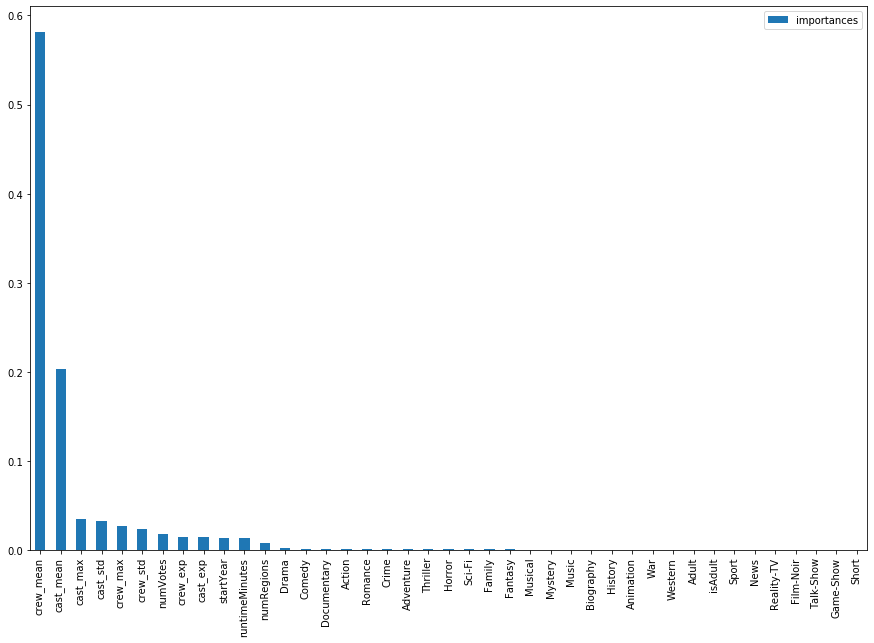

In [54]:
imp.plot.bar(figsize = (15, 10))

## Baseline XGB model


In [23]:
xgb = XGBRegressor(subsample=0.8, n_jobs=-1, )

xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=-1,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.8, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [24]:
xgb.score(X_train, y_train)

0.8528961559157758

In [25]:
xgb.score(X_test, y_test)

0.8325755483882249

In [26]:
xgb.feature_importances_

array([0.00804844, 0.00584528, 0.00460978, 0.00906458, 0.26780924,
       0.02154225, 0.026933  , 0.44964457, 0.01263842, 0.02041378,
       0.00749191, 0.00620742, 0.00705716, 0.0069712 , 0.01927788,
       0.00588633, 0.00729401, 0.00596137, 0.00569865, 0.00461444,
       0.00687665, 0.00907428, 0.00654586, 0.00282292, 0.0013899 ,
       0.        , 0.0026491 , 0.00747005, 0.0037583 , 0.00551881,
       0.00362561, 0.00421406, 0.00470564, 0.00405272, 0.01692042,
       0.        , 0.00242275, 0.        , 0.00422202, 0.00454057,
       0.00618055], dtype=float32)

In [30]:
imp = pd.DataFrame({"importances": xgb.feature_importances_},index= train_cols).sort_values(by = 'importances', 
                                                                                                 ascending = False)

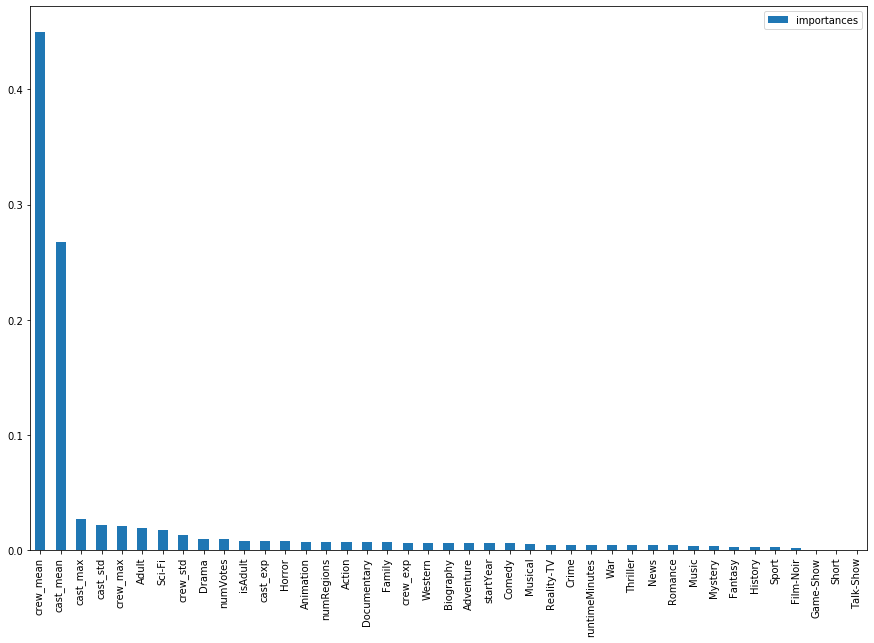

In [31]:
imp.plot.bar(figsize = (15, 10))

## A Simple Neural Net

In [107]:
def create_model(input_size):
    model = keras.Sequential()
    model.add(layers.Input(shape = (input_size, )))
    model.add(layers.Dense(32, activation = 'relu'))

    model.add(layers.Dense(64, activation = 'relu'))
    model.add(layers.Dense(128, activation = 'relu'))
    model.add(layers.Dense(64, activation = 'relu'))

    model.add(layers.Dense(32, activation = 'relu'))
    model.add(layers.Dense(1, activation = 'relu'))
    
    opt = Adam(lr=1e-4, decay=1e-3 / 200)
    model.compile(loss = 'mse', optimizer=opt)
    
    return model

In [108]:
model = create_model(X.shape[1])

/home/tanmay/anaconda3/lib/python3.7/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [109]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_39 (Dense)            (None, 32)                1344      
                                                                 
 dense_40 (Dense)            (None, 64)                2112      
                                                                 
 dense_41 (Dense)            (None, 128)               8320      
                                                                 
 dense_42 (Dense)            (None, 64)                8256      
                                                                 
 dense_43 (Dense)            (None, 32)                2080      
                                                                 
 dense_44 (Dense)            (None, 1)                 33        
                                                                 
Total params: 22,145
Trainable params: 22,145
Non-trai

In [110]:
history = model.fit(X_train, y_train, 
          validation_data=(X_test, y_test), 
          batch_size = 512, workers = -1, epochs = 40, verbose = 1)

Epoch 1/40
443/443 [==============================] - 2s 3ms/step - loss: 13.0978 - val_loss: 2.2463
Epoch 2/40
443/443 [==============================] - 1s 3ms/step - loss: 2.2184 - val_loss: 1.1900
Epoch 3/40
443/443 [==============================] - 1s 3ms/step - loss: 1.1761 - val_loss: 0.7598
Epoch 4/40
443/443 [==============================] - 1s 3ms/step - loss: 0.7025 - val_loss: 0.5417
Epoch 5/40
443/443 [==============================] - 1s 3ms/step - loss: 0.5142 - val_loss: 0.4593
Epoch 6/40
443/443 [==============================] - 1s 3ms/step - loss: 0.4439 - val_loss: 0.4243
Epoch 7/40
443/443 [==============================] - 1s 3ms/step - loss: 0.4158 - val_loss: 0.4048
Epoch 8/40
443/443 [==============================] - 1s 3ms/step - loss: 0.3988 - val_loss: 0.3913
Epoch 9/40
443/443 [==============================] - 1s 3ms/step - loss: 0.3873 - val_loss: 0.3820
Epoch 10/40
443/443 [==============================] - 1s 3ms/step - loss: 0.3790 - val_loss: 0.376

In [111]:
y_train_pred = model.predict(X_train)

In [112]:
y_test_pred = model.predict(X_test)

In [113]:
r2_score(y_train_pred, y_train)

0.7860020004576371

In [114]:
r2_score(y_test_pred, y_test)

0.7840550603733157

## Hyperparamerter tuning

To get the best performance out of the mode, I used hyperopt to find an optimal set of hyperparameters for our XGBoost model

In [117]:
search_space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
            'gamma': hp.uniform ('gamma', 1,9),
            'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
            'reg_lambda' : hp.uniform('reg_lambda', 0,1),
            'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
            'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
            'n_estimators': 180,
            'seed': 0}

In [200]:
# XGB parameters
xgb_reg_params = {
    'learning_rate':    hp.quniform('learning_rate',    np.arange(0.05, 0.31, 0.05, dtype=float)),
    'max_depth':        hp.choice('max_depth',        np.arange(5, 16, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.uniform('colsample_bytree', np.arange(0.3, 0.8, 0.1, dtype=float)),
    'subsample':        hp.quniform('subsample', 0.8, 1),
    'n_estimators':     100,
     'n_jobs': -1
}
xgb_fit_params = {
    'eval_metric': 'rmse',
    'early_stopping_rounds': 10,
    'verbose': False
}
xgb_para = dict()
xgb_para['reg_params'] = xgb_reg_params
xgb_para['fit_params'] = xgb_fit_params
xgb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [207]:
# XGB parameters
xgb_reg_params = {
    'learning_rate':    hp.quniform('learning_rate', 0.05, 0.31, 0.05),
    'max_depth':        hp.choice('max_depth',        np.arange(5, 16, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.3, 0.8, 0.1),
    'subsample':        hp.uniform('subsample', 0.8, 1),
    'n_estimators':     100,
     'n_jobs': -1
}
xgb_fit_params = {
    'eval_metric': 'rmse',
    'early_stopping_rounds': 10,
    'verbose': False
}
xgb_para = dict()
xgb_para['reg_params'] = xgb_reg_params
xgb_para['fit_params'] = xgb_fit_params
xgb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

In [208]:
xgb_para

{'reg_params': {'learning_rate': <hyperopt.pyll.base.Apply at 0x7f23f0156e10>,
  'max_depth': <hyperopt.pyll.base.Apply at 0x7f23f01564d0>,
  'min_child_weight': <hyperopt.pyll.base.Apply at 0x7f23f01568d0>,
  'colsample_bytree': <hyperopt.pyll.base.Apply at 0x7f23f01664d0>,
  'subsample': <hyperopt.pyll.base.Apply at 0x7f23f013cc50>,
  'n_estimators': 100,
  'n_jobs': -1},
 'fit_params': {'eval_metric': 'rmse',
  'early_stopping_rounds': 10,
  'verbose': False},
 'loss_func': <function __main__.<lambda>(y, pred)>}

In [213]:
def objective(xgb_para):
#     print(xgb_para)
    reg=XGBRegressor( **xgb_para['reg_params'])
    
    evaluation = [(X_train, y_train), ( X_test, y_test)]
    
    reg.fit(X_train, y_train,
            eval_set=evaluation,
            eval_metric = xgb_para['fit_params']['eval_metric'],
            early_stopping_rounds=xgb_para['fit_params']['early_stopping_rounds'],
            verbose=False)
    

    pred = reg.predict(X_test)
#     r2 = r2_score(y_test, pred)
#     print ("SCORE:", r2)
    loss = xgb_para['loss_func'](y_test, pred)
    return {'loss': loss, 'status': STATUS_OK }

In [214]:
trials = Trials()

In [ ]:
best_hyperparams = fmin(fn = objective,
                        space = xgb_para,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

  8%|▊         | 8/100 [03:00<43:04, 28.10s/trial, best loss: 0.5519333960963705]

In [ ]:
best_hyperparams

In [ ]:
reg=XGBRegressor( **best_hyperparams)
    
evaluation = [(X_train, y_train), ( X_test, y_test)]

reg.fit(X_train, y_train,
        eval_set=evaluation,
        eval_metric = xgb_para['fit_params']['eval_metric'],
        early_stopping_rounds=xgb_para['fit_params']['early_stopping_rounds'],
        verbose=True)